## 02. Neural Network Classification in PyTorch

### 0.  Architecture

- input layer shape -> in_features
- hidden layer(s)
- neurons per hidden layer -> generally 10 to 512
- output layer shape -> out_features
- hidden layer activation -> usually ReLU
- output activation -> usually Sigmoid / Softmax
- loss function -> (binary) cross entropy (torch.nn.BCELoss / torch.nn.CrossEntropyLoss)
- optimizer -> SGD/Adam

### 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
# make dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


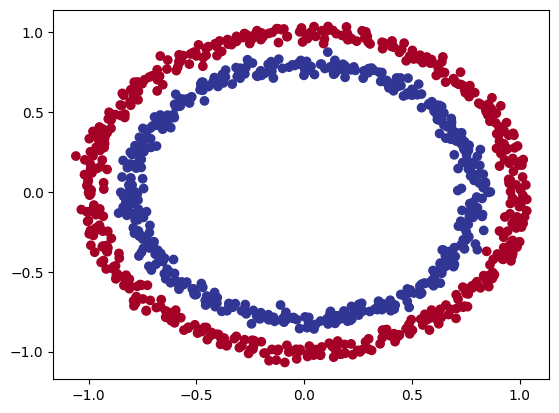

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu)

**Find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).**

`Note:` this dataset is often referred to as a `toy dataset` -> small enough to experiment but still sizeable to practice the fundamentals

### 1.1 Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print("Values for one sample of X:", X_sample, " and for y:", y_sample)
print("Shape for one sample of X:", X_sample.shape, " and for y:", y_sample.shape)

Values for one sample of X: [0.75424625 0.23148074]  and for y: 1
Shape for one sample of X: (2,)  and for y: ()


### 1.2 Turn data into Tensors and Split train and test set

In [7]:
# turn into tensors
import torch

torch.__version__

'2.1.0.dev20230709'

In [8]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
# split data into training and testing dataset
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size= 0.2,
                                                   random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Build the model

Build the model to classify blue and red dots:
- (1) setup device agonistic code -> run on GPU if available
- (2) construct a model (2 `nn.Linear` layers)
- (3) define a loss and optimizer
- (4) create a training and testing loop

In [13]:
import torch
from torch import nn

device = "mps" if getattr(torch, 'has_mps', False) \
    else "gpu" if torch.cuda.is_available() else "cpu"
device

/var/folders/df/mx2gggdn7p55_8g8_fxxk8zc0000gn/T/ipykernel_93273/3865436524.py:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) \


'mps'

In [14]:
# create a model class
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # create 2 nn.linear layers
        # takes in 2 features and upscale to 5 features -> 5 hidden layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        # takes in 5 features from previous layer and outputs a single feature
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

        """
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )
        """

    def forward(self, x):
        # x -> layer_1 -> layer_2 -> output
        return self.layer_2(self.layer_1(x))

        """ return self.two_linear_layers(x) """

- tensorflow playground - a visual example of what a similar classificiation neural network looks like
- figma

In [15]:
# inatantiate an instance
model_0 = CircleModelV0().to(device)
model_0, next(model_0.parameters()).device

(CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 device(type='mps', index=0))

In [16]:
# replicate using `nn.Sequential()`

# performs a forward pass computation of the input data through the layers in
# the order they appear
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
print('model parameters before training:')
model_0.state_dict()

model parameters before training:


/Users/wzy/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:248.)
  nonzero_finite_vals = torch.masked_select(


OrderedDict([('0.weight',
              tensor([[ 0.4071, -0.1937],
                      [-0.5100,  0.1211],
                      [-0.2744, -0.6157],
                      [ 0.3639,  0.6223],
                      [ 0.5596,  0.2945]], device='mps:0')),
             ('0.bias',
              tensor([ 0.5353,  0.3580,  0.2754,  0.3889, -0.6684], device='mps:0')),
             ('1.weight',
              tensor([[-0.1843, -0.4309, -0.0664, -0.2647, -0.0654]], device='mps:0')),
             ('1.bias', tensor([0.2271], device='mps:0'))])

In [18]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print("Length of predictions:", len(untrained_preds), ", shape:", untrained_preds.shape)
print("Length of test samples:", len(y_test), "Shape:", y_test.shape)
print("\nFirst 10 predictions:\n", torch.round(untrained_preds[:10]))
print("\nFirst 10 test labels:\n", y_test[:10])


Length of predictions: 200 , shape: torch.Size([200, 1])
Length of test samples: 200 Shape: torch.Size([200])

First 10 predictions:
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='mps:0')

First 10 test labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

-> problem specific

**PyTorch binary cross entropy:**
- `torch.nn.BCELoss():` Creates a loss function that measures the binary cross entropy between the target (label) and input (features)
- `torch.nn.BCEWithLogitsLoss():` the same as above except it has a sigmoid layer (`nn.Sigmoid`) built-in


=> logits in deep learning: https://saturncloud.io/blog/what-is-the-meaning-of-the-word-logits-in-tensorflow/

In [19]:
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in

"""
nn.Sequential(
    nn.Sigmoid(),
    nn.BCELoss()
)   # similar to nn.BCEWithLogitsLoss()
"""

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
# create accuracy metrics
def accuracy_fn(y_true, y_pred):
    # torch.eq() calculates where two tensors are equal
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

### 3. Train model

### 3.1 Goingfrom raw logits -> prediction probabilities -> prediction labe;s

The model outputs are going to be `raw logits`.

Can convert these `logits` into prediction probabilities by passing them to `activation function`.
e.g. sogmoid/softmax.

Then, convert model's prediction probabilities to `prediction labels` by either **rounding** or taking the **argmax()**.

`Note: '.eval()'` -> a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time

In [21]:
# view the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2235],
        [-0.2560],
        [-0.0742],
        [-0.2661],
        [ 0.0274]], device='mps:0')

In [22]:
# use sigmoid activation function on model logits -> turn into prediction probability
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4444],
        [0.4363],
        [0.4814],
        [0.4339],
        [0.5069]], device='mps:0')

In [23]:
# pass to round function to get prediction labels
y_preds = torch.round(y_pred_probs)

# in full:
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 0., 0., 1.], device='mps:0')

### 3.2 Build training and testing loop

In [24]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate the loss/accuracy
    # nn.BCEWithLogitsLoss() -> expect raw logits as input
    # nn.BCELoss() -> expect prediction probabilities as input
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # zero the optimizer
    optimizer.zero_grad()
    # backpropagattion
    loss.backward()
    # GD
    optimizer.step()

    # testing code
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        t_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if (epoch % 10 == 0):
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {t_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69655 | Acc: 45.38 | Test loss: 0.69287 | Test Acc: 49.00%
Epoch: 10 | Train Loss: 0.69529 | Acc: 47.88 | Test loss: 0.69211 | Test Acc: 51.00%
Epoch: 20 | Train Loss: 0.69467 | Acc: 48.25 | Test loss: 0.69199 | Test Acc: 50.50%
Epoch: 30 | Train Loss: 0.69430 | Acc: 48.88 | Test loss: 0.69208 | Test Acc: 50.50%
Epoch: 40 | Train Loss: 0.69403 | Acc: 48.88 | Test loss: 0.69225 | Test Acc: 51.00%
Epoch: 50 | Train Loss: 0.69383 | Acc: 49.12 | Test loss: 0.69245 | Test Acc: 50.50%
Epoch: 60 | Train Loss: 0.69368 | Acc: 49.50 | Test loss: 0.69264 | Test Acc: 50.50%
Epoch: 70 | Train Loss: 0.69355 | Acc: 50.00 | Test loss: 0.69283 | Test Acc: 48.50%
Epoch: 80 | Train Loss: 0.69345 | Acc: 50.88 | Test loss: 0.69300 | Test Acc: 47.50%
Epoch: 90 | Train Loss: 0.69337 | Acc: 50.00 | Test loss: 0.69316 | Test Acc: 47.50%


### 4. Make predictions and evaluate the model

looks like didn't learn anything...

-> import a function called `plot_decision_boundary()`

In [25]:
# make some presiction and visualize them
import requests
from pathlib import Path

# download helper function
if Path("helper_function.py").is_file():
    print("file already exists, skipping download.")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


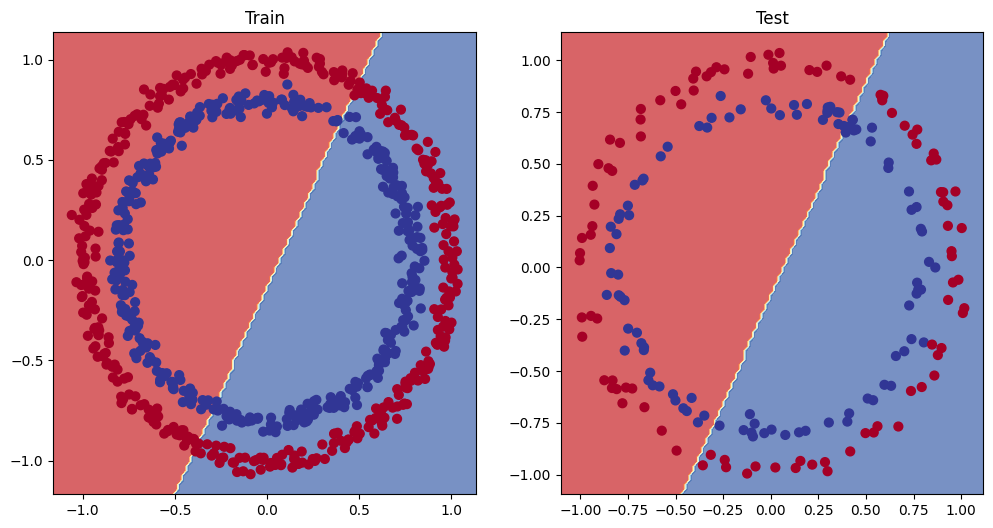

In [26]:
# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5. Improving a model (from a model perpective)

- add more layers -> more chances to learn about patterns in the data
- add more hidden layers
- fit for longer
- changeing the activation function
- change the learning rate
- change the loss function


In [27]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        # add more hidden units
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        # add more layers
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # x -> layer_1 -> layer_2 -> layer_3 -> output
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [28]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
# loss function
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [30]:
torch.manual_seed(42)

# put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    ### Training
    model_1.train()

    # forward pass
    y_logits = model_1(X_train).squeeze()
    # logits -> prediction probs -> pred labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate the loss/accuracy
    # nn.BCEWithLogitsLoss() -> expect raw logits as input
    # nn.BCELoss() -> expect prediction probabilities as input
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # zero the optimizer
    optimizer.zero_grad()
    # backpropagattion
    loss.backward()
    # GD
    optimizer.step()

    # testing code
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        t_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if (epoch % 100 == 0):
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {t_loss:.5f} | Test Acc: {test_acc:.2f}%")
    


Epoch: 0 | Train Loss: 0.69395 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 100 | Train Loss: 0.69305 | Acc: 50.38% | Test loss: 0.69379 | Test Acc: 48.00%
Epoch: 200 | Train Loss: 0.69299 | Acc: 51.12% | Test loss: 0.69437 | Test Acc: 46.00%
Epoch: 300 | Train Loss: 0.69298 | Acc: 51.62% | Test loss: 0.69458 | Test Acc: 45.00%
Epoch: 400 | Train Loss: 0.69298 | Acc: 51.12% | Test loss: 0.69465 | Test Acc: 46.00%
Epoch: 500 | Train Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69467 | Test Acc: 46.00%
Epoch: 600 | Train Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69468 | Test Acc: 46.00%
Epoch: 700 | Train Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69468 | Test Acc: 46.00%
Epoch: 800 | Train Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69468 | Test Acc: 46.00%
Epoch: 900 | Train Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69468 | Test Acc: 46.00%


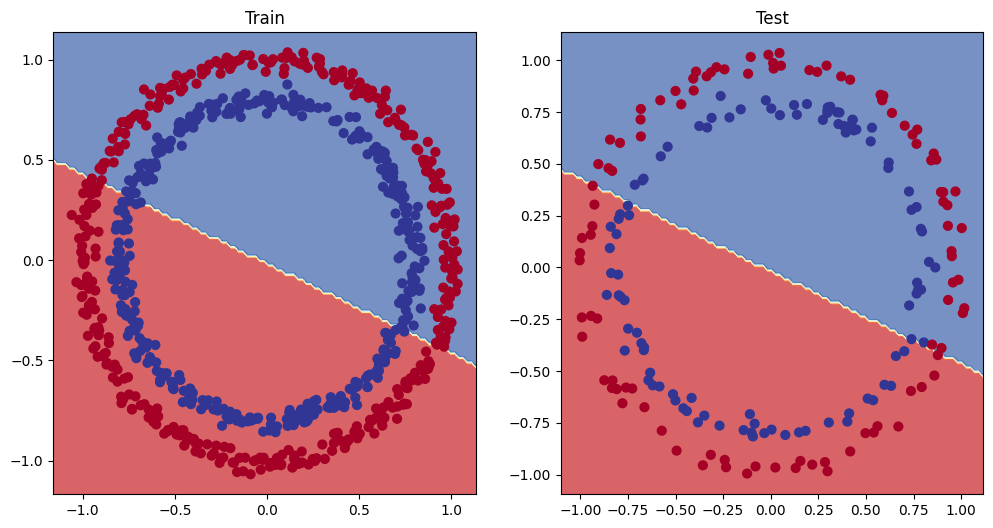

In [31]:
# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

no changes

### 6. Non-linearity

### 6.1 Recreating non-linear data

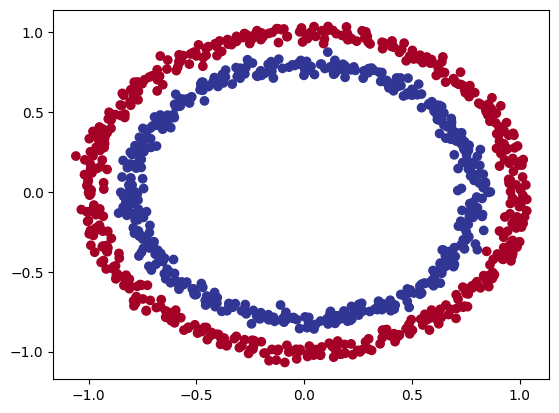

In [32]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [33]:
# convert into tensors and split data into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [34]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [35]:
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [36]:
# setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)


### 6.3 Train the model with non-linear

In [37]:
torch.manual_seed(42)

# put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 2000

for epoch in range(epochs):
    ### Training
    model_2.train()

    # forward pass
    y_logits = model_2(X_train).squeeze()
    # logits -> prediction probs -> pred labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate the loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # zero the optimizer
    optimizer.zero_grad()
    # backpropagattion
    loss.backward()
    # GD
    optimizer.step()

    # testing code
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        t_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if (epoch % 100 == 0):
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {t_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69295 | Acc: 50.00% | Test loss: 0.69319 | Test Acc: 50.00%
Epoch: 100 | Train Loss: 0.69115 | Acc: 52.88% | Test loss: 0.69102 | Test Acc: 52.50%
Epoch: 200 | Train Loss: 0.68977 | Acc: 53.37% | Test loss: 0.68940 | Test Acc: 55.00%
Epoch: 300 | Train Loss: 0.68795 | Acc: 53.00% | Test loss: 0.68723 | Test Acc: 56.00%
Epoch: 400 | Train Loss: 0.68517 | Acc: 52.75% | Test loss: 0.68411 | Test Acc: 56.50%
Epoch: 500 | Train Loss: 0.68102 | Acc: 52.75% | Test loss: 0.67941 | Test Acc: 56.50%
Epoch: 600 | Train Loss: 0.67515 | Acc: 54.50% | Test loss: 0.67285 | Test Acc: 56.00%
Epoch: 700 | Train Loss: 0.66659 | Acc: 58.38% | Test loss: 0.66322 | Test Acc: 59.00%
Epoch: 800 | Train Loss: 0.65160 | Acc: 64.00% | Test loss: 0.64757 | Test Acc: 67.50%
Epoch: 900 | Train Loss: 0.62362 | Acc: 74.00% | Test loss: 0.62145 | Test Acc: 79.00%
Epoch: 1000 | Train Loss: 0.56818 | Acc: 87.75% | Test loss: 0.57378 | Test Acc: 86.50%
Epoch: 1100 | Train Loss: 0.48153 | Acc: 93.

### 6.4 Evaluate the non-linear model

In [38]:
# make predictions
model_2.eval()
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model_2(X_test))).squeeze()

y_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'))

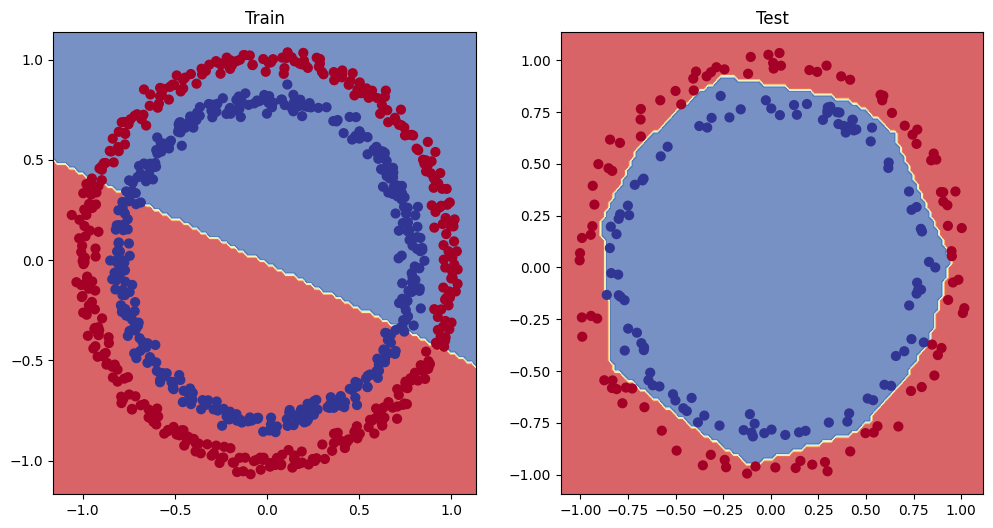

In [39]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_2 = has non-linearity